# Adding Different LLM Modalities to Exisiting Agents

### This notebook showcases how to add image generation modality as a conversable agent capability 

We first need to make sure you have the right dependencies installed.
If you are installing autogen from source, run the following command inside the base directory:
- `pip install -e .[lmm]`

If you're not installing autogen from source, run the following command:
- `pip install "pyautogen[lmm]"`

First lets import all the required modules to run this example

In [1]:
import os
import re
from typing import Dict, Optional

from PIL.Image import Image

import autogen
from autogen.cache import Cache
from autogen.agentchat.contrib import img_utils
from autogen.agentchat.contrib.capabilities import generate_images
from autogen.oai import openai_utils
from IPython.display import display

Let's define our LLM configs (you can experiment with different params)

In [11]:
gpt_config = {
    "config_list": [{"model": "gpt-4-turbo-preview", "api_key": os.environ["OPENAI_API_KEY"]}],
    "timeout": 120,
    "temperature": 0.7,
}
gpt_vision_config = {
    "config_list": [{"model": "gpt-4-vision-preview", "api_key": os.environ["OPENAI_API_KEY"]}],
    "timeout": 120,
    "temperature": 0.7,
}
dalle_config = {
    "config_list": [{"model": "dall-e-3", "api_key": os.environ["OPAI_API_KEY"]}],
    "timeout": 120,
    "temperature": 0.7,
}

Our system will consist of 2 main agents:
1. Image generator agent
2. Critic agent

The image generator agent will carry a conversation with the critic, and generate images based on the critic's requests.

In [4]:
CRITIC_SYSTEM_MESSAGE = """You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of color, shape, text (clarity), and other things.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!
"""

In [12]:
def critic_agent() -> autogen.ConversableAgent:
    return autogen.ConversableAgent(
        name="critic",
        llm_config=gpt_vision_config,
        system_message=CRITIC_SYSTEM_MESSAGE,
        max_consecutive_auto_reply=3,
        human_input_mode="NEVER",
    )


def image_generator_agent() -> autogen.ConversableAgent:
    # Create the agent
    agent = autogen.ConversableAgent(
        name="dalle", llm_config=gpt_vision_config, max_consecutive_auto_reply=3, human_input_mode="NEVER"
    )
    cache = Cache.disk()

    # Add image generation ability to the agent
    dalle_gen = generate_images.DalleImageGenerator(llm_config=dalle_config)
    image_gen_capability = generate_images.ImageGeneration(
        image_generator=dalle_gen, cache=cache, text_analyzer_llm_config=gpt_config()
    )

    image_gen_capability.add_to_agent(agent)
    return agent

We'll define `extract_img` to help us extract the image generated by the image generator agent.

In [6]:
def extract_images(sender: autogen.ConversableAgent, recipient: autogen.ConversableAgent) -> Image:
    images = []
    all_messages = sender.chat_messages[recipient]

    for message in reversed(all_messages):
        # The GPT-4V format, where the content is an array of data
        contents = message.get("content", [])
        for content in contents:
            if isinstance(content, str):
                continue
            if content.get("type", "") == "image_url":
                img_data = content["image_url"]["url"]
                images.append(img_utils.get_pil_image(img_data))

    if not images:
        raise ValueError("No image data found in messages.")

    return images

Start the converstion

In [7]:
dalle = image_generator_agent()
critic = critic_agent()

img_prompt = "a happy dog wearing a shirt saying 'I Love AutoGen', make sure the text is clear"
# img_prompt = "Ask me how I'm doing"

result = dalle.initiate_chat(critic, message=img_prompt)

dalle (to critic):

a happy dog wearing a shirt saying 'I Love AutoGen', make sure the text is clear

--------------------------------------------------------------------------------
critic (to dalle):

CRITICS: The image needs to improve on the color contrast between the text on the shirt and the shirt itself to ensure the message 'I Love AutoGen' stands out. The shape of the dog should be distinct and recognizable as a happy dog. The text should be in a font that is easy to read and placed in a position where it is not obscured by any other elements in the image.

PROMPT: Create an image of a cheerful dog with a distinct shape that embodies happiness, wearing a brightly colored shirt with high contrast to the text color. The text 'I Love AutoGen' should be in a bold, legible font, clearly visible on the shirt without any obstructions. Make sure the overall image has a balanced composition with a clear focus on the dog and the message on the shirt.

-----------------------------------

Let's display all the images that was generated by Dalle

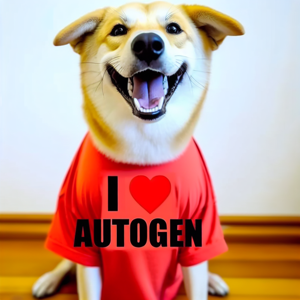

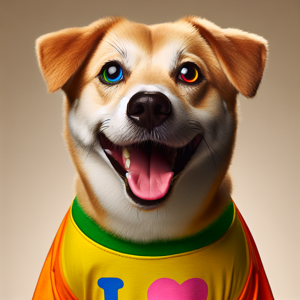

In [8]:
images = extract_images(dalle, critic)

for image in reversed(images):
    display(image.resize((300, 300)))